# Introduction
This notebook trains supervised machine learning models using processed data from data_preprocessing.ipynb and produces the final XGBoost champion model data used in our MVP.

# Notebook Setup

In [ ]:
import os
import re
import gc
import numpy as np
from numpy import int64
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from xgboost import plot_tree
from xgboost import plot_importance
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

# Install library for use with TabNet supervised model
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

## Notebook Functions / Variables

In [ ]:
# Specify project directory filepaths under the root of personal Google Drive
user_proj_path = ''

## Connecting Google Drive for data storage

In [ ]:
# Mount Google Drive and confirm access permissions to permitaccess for data located on Google Drive
from google.colab import drive
drive.mount('/content/drive')

proj_dir = '/content/drive/MyDrive/' + user_proj_path + 'plodi/'
proj_dir_data_raw = proj_dir + 'data/raw/'
proj_dir_data_proc = proj_dir + 'data/processed/'

dirs = [proj_dir, proj_dir_data_raw, proj_dir_data_proc]

for dir in dirs:
    print('-----------------------------------------------------------------------')
    print('Directory contents for ', dir)
    %ls {dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/
data/  notebooks/
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/data/raw/
2-6%20digit_2017_Codes.xlsx      public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
2-6%20digit_2022_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2017_Codes.xlsx          public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
6-digit_2022_Codes.xlsx          public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx         public_up_to_150k_3_230630.csv   sba_ppp_combined.csv
public_150k_plus_230630.csv      public_up_to_150k_4_230630.csv   sba_ppp_merged.csv
public_up_to_150k_10_230630.csv 

In [ ]:
# drive.mount("/content/drive", force_remount=True) # Run if the Google drive needs to be remounted

Mounted at /content/drive


In [ ]:
# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

## Identifying instance system specifications

In [ ]:
# Check Colab Pro / Local instance specs
# !df -h
# !cat /proc/cpuinfo
# !cat /proc/meminfo

## Load Preprocessed Data and Model Downsampled Test / Train Data

In [ ]:
# Read in the modeling data
index_col = 'LoanNumber'

X_train = pd.read_csv(
    proj_dir_data_proc+'x_train.csv', header=0, index_col=index_col)
X_test = pd.read_csv(
    proj_dir_data_proc+'x_test.csv', header=0, index_col=index_col)
y_train = pd.read_csv(
    proj_dir_data_proc+'y_train.csv', header=0, index_col=index_col)
y_test = pd.read_csv(
    proj_dir_data_proc+'y_test.csv', header=0, index_col=index_col)

# Full data
df_labelled = pd.read_csv(
    proj_dir_data_proc+'modelling_data_cat_preproc.csv', header=0, index_col=index_col)
df_labelled.rename(
    columns={'CaseLabel_cat': 'Labelled_Loan_Binary'}, inplace = True) # Renaming column to align with prior code

# Categorical variable data dictionary
df_cat_dict = pd.read_csv(
    proj_dir_data_proc+'modelling_data_cat_dict.csv', header=0, index_col='Cat_Code')

# Store feature column names
col_names = X_train.columns

# Supervised Learning

## Baseline Model "No Fraud"

In [ ]:
#assume no fraud ergo 0
preds = np.zeros(X_test.shape[0])

# Print classification report
print(classification_report(y_test.Labelled_Loan_Binary, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9202    1.0000    0.9584      1441
           1     0.0000    0.0000    0.0000       125

    accuracy                         0.9202      1566
   macro avg     0.4601    0.5000    0.4792      1566
weighted avg     0.8467    0.9202    0.8819      1566



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression No Regularization

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9308    0.9986    0.9635      1441
           1     0.9000    0.1440    0.2483       125

    accuracy                         0.9304      1566
   macro avg     0.9154    0.5713    0.6059      1566
weighted avg     0.9283    0.9304    0.9064      1566



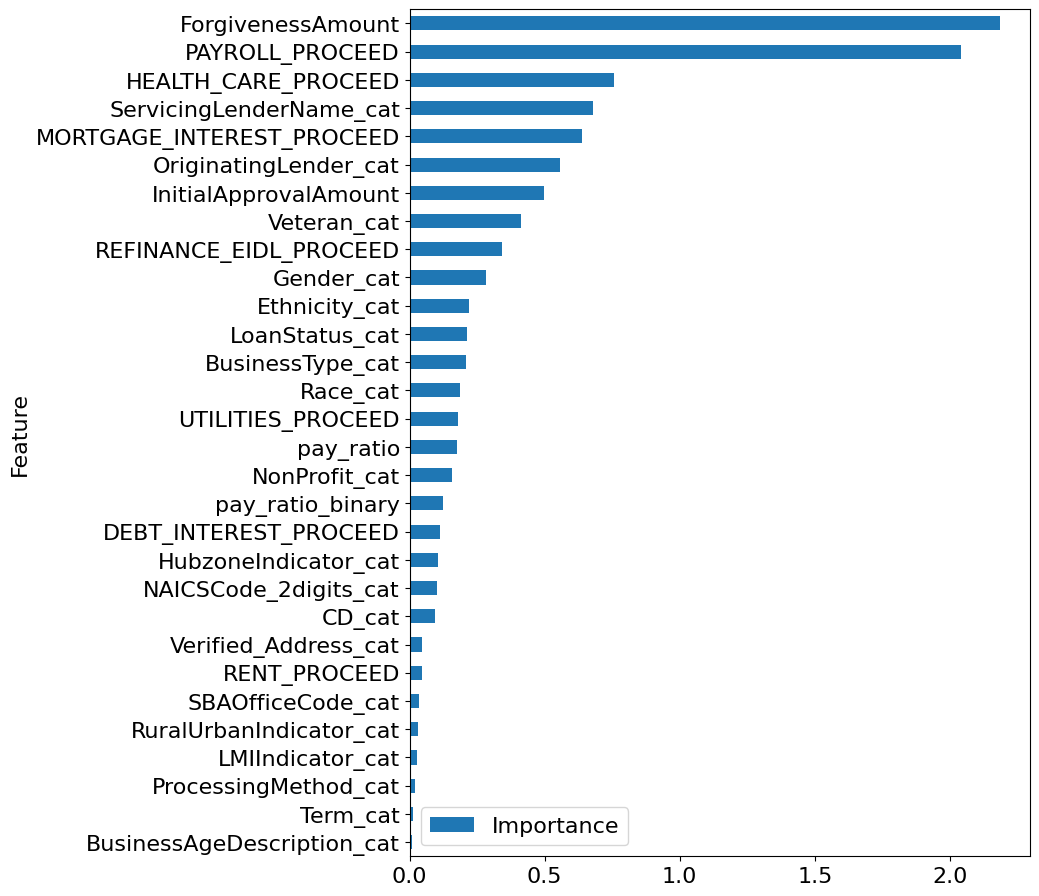

In [ ]:
#normalize features for interpretation
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

#fit model
model = LogisticRegression(penalty = None, solver = 'saga', max_iter = 1000)
model.fit(X_train_lr, y_train.Labelled_Loan_Binary)

#plot normalized feature imporance
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': col_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 11))

#get predictions on the test set
preds = model.predict(X_test_lr)
#probability version
y_pred_probs = model.predict_proba(X_test_lr)

# Print classification report
print(classification_report(y_test.Labelled_Loan_Binary, preds, digits=4))

## MLP Neural Network

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100, 100,100), max_iter = 1000, alpha=0.0001, random_state=1, tol=0.000000001)

model.fit(X_train, y_train)

#get predictions on the test set
preds = model.predict(X_test)
#probability version
y_pred_probs = model.predict_proba(X_test)

# Print classification report
print(classification_report(y_test, preds, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0     0.9383    0.9285    0.9334      1441
           1     0.2643    0.2960    0.2792       125

    accuracy                         0.8780      1566
   macro avg     0.6013    0.6123    0.6063      1566
weighted avg     0.8845    0.8780    0.8812      1566



## KNN

In [ ]:
model = KNeighborsClassifier(n_neighbors=75)
model.fit(X_train, y_train)

#get predictions on the test set
preds = model.predict(X_test)
#probability version
y_pred_probs = model.predict_proba(X_test)

# Print classification report
print(classification_report(y_test, preds, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0     0.9356    0.9979    0.9657      1441
           1     0.8966    0.2080    0.3377       125

    accuracy                         0.9349      1566
   macro avg     0.9161    0.6030    0.6517      1566
weighted avg     0.9325    0.9349    0.9156      1566



## TabNet

In [ ]:
# https://www.kaggle.com/code/carlmcbrideellis/tabnet-simple-binary-classification-example
# https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#tabnet-attentive-interpretable-tabular-learning
# https://www.kaggle.com/code/optimo/tabnet-with-loop-feature-engineering-explained

X_train_tn = X_train.to_numpy()
y_train_tn = y_train.to_numpy()

y_train_tn = y_train_tn.flatten()

classifier = TabNetClassifier(verbose=0, seed=42)
classifier.fit(X_train=X_train_tn, y_train=y_train_tn,
               patience=5, max_epochs=100,
               eval_metric=['logloss'])

preds = classifier.predict(X_test.to_numpy())

# Print classification report
print(classification_report(y_test.to_numpy().flatten(), preds, digits=4))

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0     0.9367    0.9958    0.9654      1441
           1     0.8235    0.2240    0.3522       125

    accuracy                         0.9342      1566
   macro avg     0.8801    0.6099    0.6588      1566
weighted avg     0.9277    0.9342    0.9164      1566



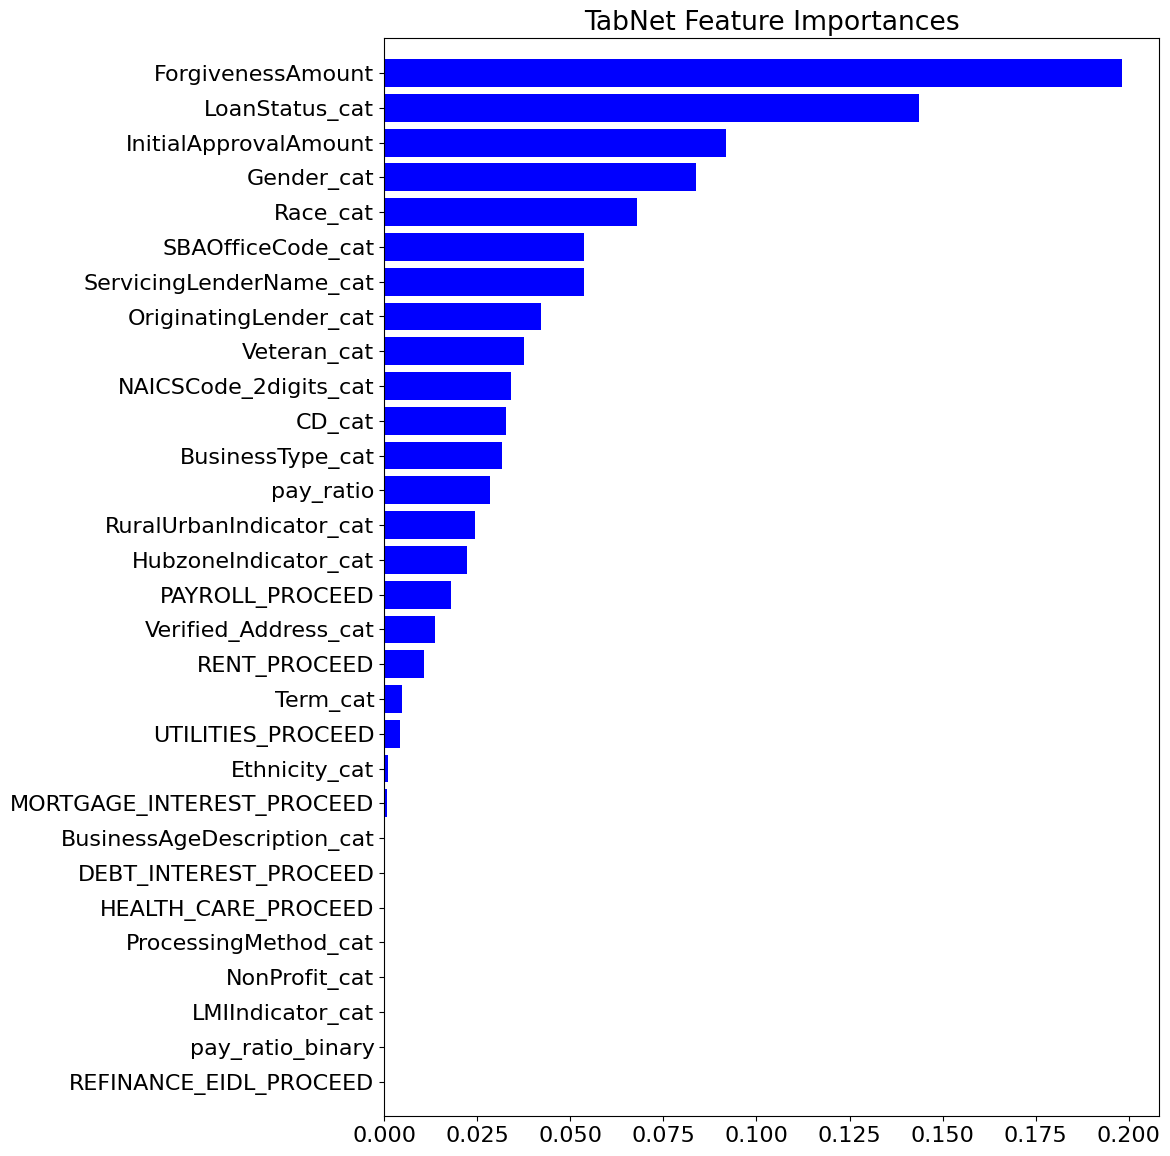

In [ ]:
#Graph feature importances
feat_importances = classifier.feature_importances_
indices = np.argsort(feat_importances)

plt.rcParams.update({'font.size': 16})

plt.figure()
plt.title("TabNet Feature Importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],
       color="b", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
feats = X_test.columns
plt.yticks(range(len(feat_importances)), [feats[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show()

## XGBoost

In [ ]:
#Define the XGBoost model
model = xgb.XGBClassifier(feature_names=col_names)
#fit on the training data
model.fit(X_train, y_train.Labelled_Loan_Binary)

# #plot feature importance
# plot_importance(model)
# plt.rcParams["figure.figsize"] = (8, 11)
# plt.show()

#get predictions on the test set
preds = model.predict(X_test)
#probability version
y_pred_probs = model.predict_proba(X_test)

# Print classification report
print(classification_report(y_test.Labelled_Loan_Binary, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9506    0.9889    0.9694      1441
           1     0.7612    0.4080    0.5312       125

    accuracy                         0.9425      1566
   macro avg     0.8559    0.6984    0.7503      1566
weighted avg     0.9355    0.9425    0.9344      1566



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:15:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_names" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#Get scoring for the top N most suspect loans

#convert to DFs for merging
df_y_test = y_test.copy(deep=True)
df_preds = pd.DataFrame(preds, columns=['preds'])
df_y_test.reset_index(drop=True, inplace=True)
df_preds.reset_index(drop=True, inplace=True)

# Combine dataframes for metric evals
df_xgb_test_preds = pd.concat([df_y_test, df_preds], axis=1)
#sort the results based on the top N predicted values
df_xgb_test_preds.sort_values('preds', ascending=False, inplace=True)

for n in [10, 95, 100, 300, 500, 1000, 10000]:
    df_xgb_test_preds_n = df_xgb_test_preds.iloc[:n]
    # Print classification report
    print('\nn: ', n, '\n', classification_report(df_xgb_test_preds_n.Labelled_Loan_Binary, df_xgb_test_preds_n.preds, digits=4, zero_division=1))



n:  10 
               precision    recall  f1-score   support

           0     1.0000    0.0000    0.0000         4
           1     0.6000    1.0000    0.7500         6

    accuracy                         0.6000        10
   macro avg     0.8000    0.5000    0.3750        10
weighted avg     0.7600    0.6000    0.4500        10


n:  95 
               precision    recall  f1-score   support

           0     1.0000    0.6364    0.7778        44
           1     0.7612    1.0000    0.8644        51

    accuracy                         0.8316        95
   macro avg     0.8806    0.8182    0.8211        95
weighted avg     0.8718    0.8316    0.8243        95


n:  100 
               precision    recall  f1-score   support

           0     1.0000    0.6735    0.8049        49
           1     0.7612    1.0000    0.8644        51

    accuracy                         0.8400       100
   macro avg     0.8806    0.8367    0.8346       100
weighted avg     0.8782    0.8400    0.8352

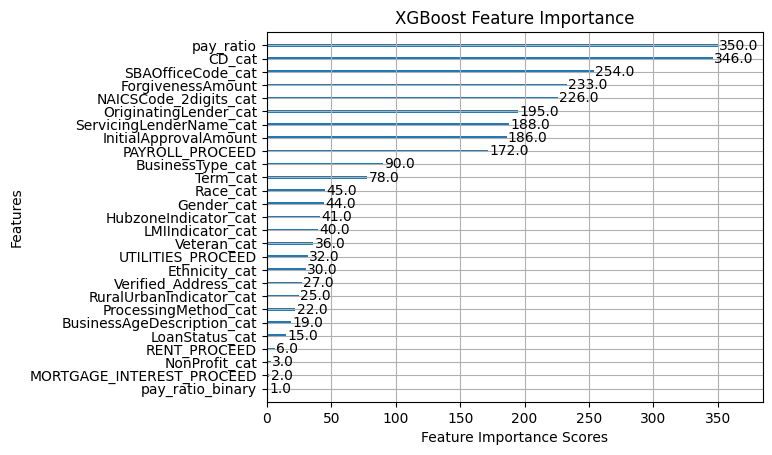

In [ ]:
# model.get_booster().feature_names = ["your", "feature", "name", "list"]
xgb.plot_importance(model.get_booster())
# plt.barh(col_names, model.feature_importances_)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

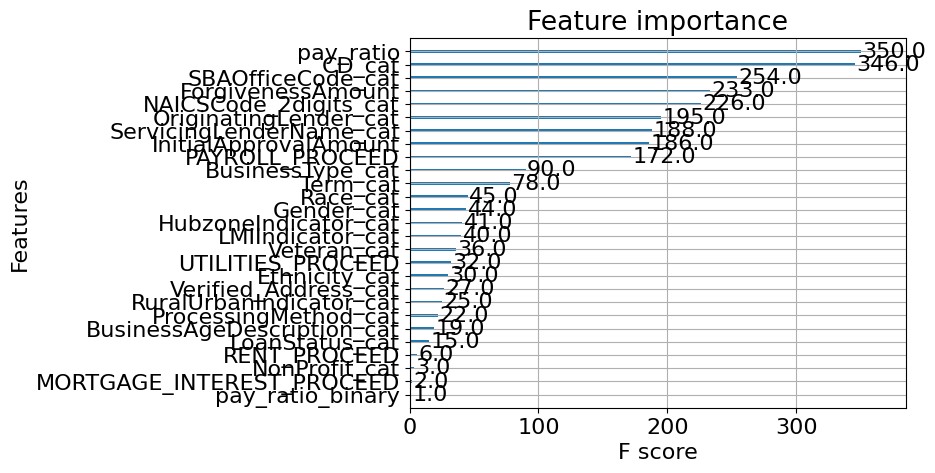

In [ ]:
# plot feature importance
plt.rcParams.update({'font.size': 16})
#plot_importance(model).set_yticklabels(col_names)
plot_importance(model)
plt.rcParams["figure.figsize"] = (10, 14)
plt.show()

## Use XGBoost as champion model and export predicted probabilities for full loan data set

In [ ]:
# Train on full train/test dataset to utilize all labelled cases

df_feat = pd.concat([X_train, X_test], axis="rows")
df_label = pd.concat([y_train, y_test], axis="rows")

In [ ]:
#define the XGBoost model
model = xgb.XGBClassifier(feature_names=col_names)

#fit on the entire train/test set prior to predicting scores for the entire
#loan data set
model.fit(df_feat, df_label['Labelled_Loan_Binary'])

#drop label and input variables that created the augmented fraud measure
df_feat_full = df_labelled.drop(['Labelled_Loan_Binary'], axis=1)

#probability version for all loans
y_pred_probs = model.predict_proba(df_feat_full)
out_0, out_1 = np.hsplit(y_pred_probs, 2)
#model.classes_

#add the scores for the fraud class
df_labelled_with_preds = df_labelled.copy(deep=True)
df_labelled_with_preds['predicted_score'] = out_1
#df_labelled_with_preds.shape

#create weighted version of predicted_score using CurrentApprovalAmount
df_labelled_with_preds['predicted_score_weighted'] = df_labelled_with_preds.predicted_score * df_labelled_with_preds.InitialApprovalAmount

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:49:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "feature_names" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#rank loans based on predicted scores
df_labelled_with_preds['suspicion_rank'] = df_labelled_with_preds.predicted_score.rank(ascending=False)
df_labelled_with_preds['suspicion_rank_weighted'] = df_labelled_with_preds.predicted_score_weighted.rank(ascending=False)
df_labelled_with_preds.sort_values('suspicion_rank_weighted', ascending=True, inplace=True)

In [ ]:
#removed protected class variables
df_labelled_with_preds_export = df_labelled_with_preds.drop(['Race_cat', 'Ethnicity_cat', 'Gender_cat', 'Veteran_cat',  'predicted_score', 'predicted_score_weighted'], axis=1)
# Save cleaned up data
df_labelled_with_preds_export.to_csv(proj_dir_data_proc+'mvp_model_data.csv', index=False)

In [ ]:
df_1 = pd.read_csv(proj_dir_data_proc+'champion_model_data.csv', header=0)
df_1.columns

Index(['Unnamed: 0', 'LoanNumber', 'Term', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'UndisbursedAmount', 'JobsReported',
       'NAICSCode', 'UTILITIES_PROCEED', 'PAYROLL_PROCEED',
       'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED',
       'HEALTH_CARE_PROCEED', 'DEBT_INTEREST_PROCEED', 'ForgivenessAmount',
       'ProcessingMethod_cat', 'LoanStatus_cat', 'RuralUrbanIndicator_cat',
       'HubzoneIndicator_cat', 'LMIIndicator_cat', 'BusinessType_cat',
       'NonProfit_cat', 'Verified_Address', 'avg_employee_pay', 'pay_ratio',
       'pay_ratio_binary', 'pay_100k', 'Fraud', 'Labelled_Loan_Binary',
       'suspicion_rank', 'suspicion_rank_weighted'],
      dtype='object')

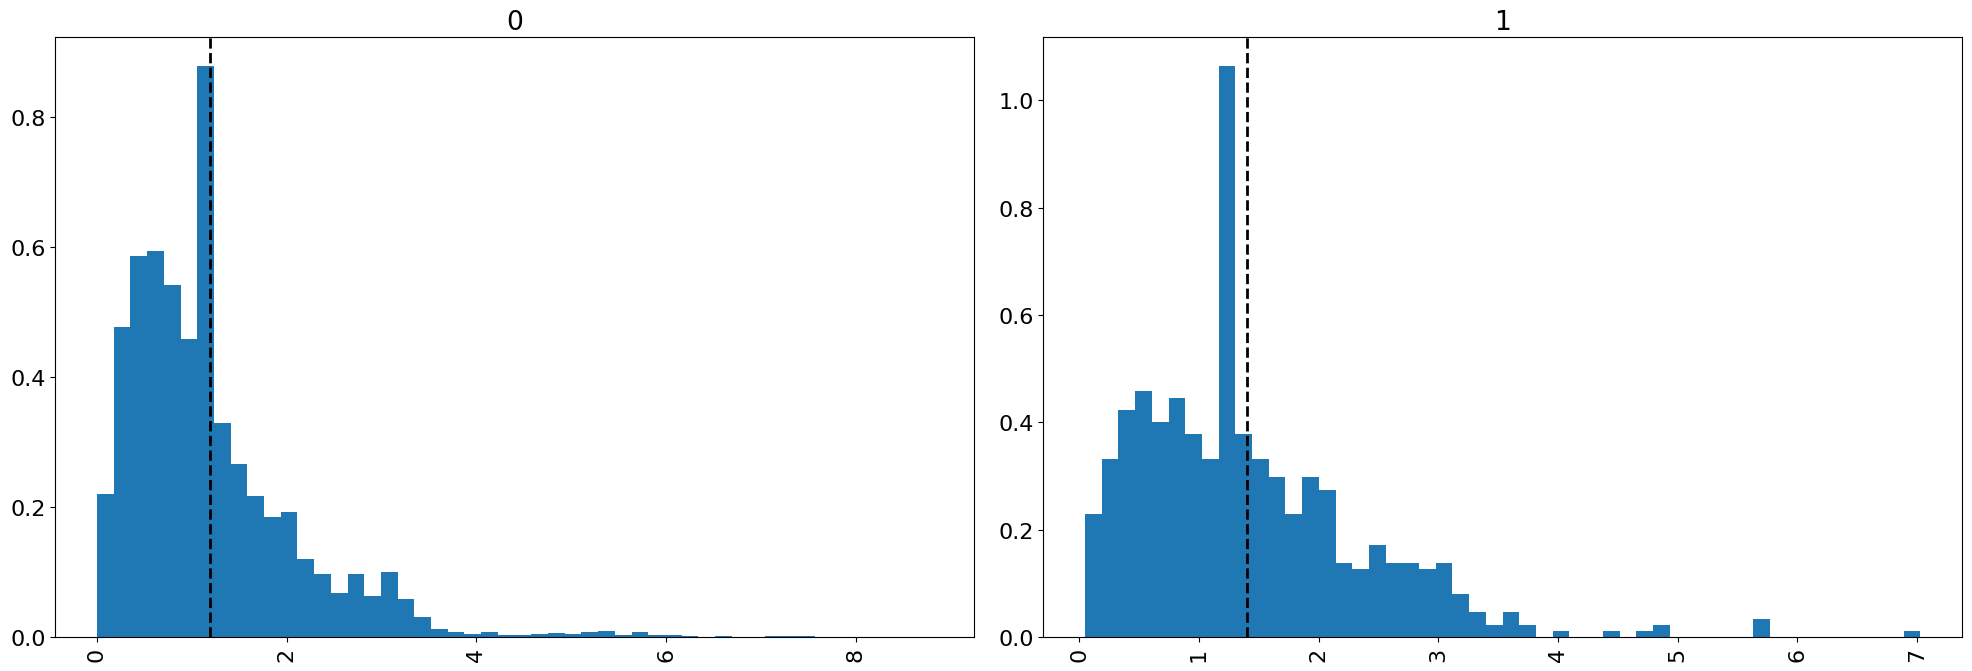

In [ ]:
#Check out pay ratio across the labelled and non-labelled loans
plt.rcParams.update({'font.size': 16})
a, b = df_labelled.hist('pay_ratio', by='Labelled_Loan_Binary', density=True, bins=50, figsize=(20, 7))
plt.tight_layout()
a.axvline(df_labelled[df_labelled['Labelled_Loan_Binary'] != 1].pay_ratio.mean(), color='black', linestyle='dashed', linewidth=2)
b.axvline(df_labelled[df_labelled['Labelled_Loan_Binary'] == 1].pay_ratio.mean(), color='black', linestyle='dashed', linewidth=2)
#df_labelled[df_labelled['Labelled_Loan_Binary'] == 1].pay_ratio.mean()